In [1]:
from create_semantic_vector import Spatial_Semantic_Vector
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

In [2]:
spatial_semantic_vector_obj = Spatial_Semantic_Vector('../data/spatial_semantics/kv_df_just_eng.pickle','../data/spatial_semantics/tag_sizes_median_df.pickle')
q_poly = Polygon([(16.36896371841431,48.20063653233946),(16.373598575592045,48.19960677385028),(16.371034383773807,48.19771882952509),(16.36772990226746,48.19816221664037)])
spatial_semantic_vector_obj.generate_vec(q_poly)

array([-1.24796540e-01, -1.30862042e-01, -4.08970722e-04, -5.49540341e-01,
        1.39643490e-01, -3.67806286e-01,  5.72290301e-01,  1.99221760e-01,
        3.69282961e-01,  6.47916496e-02,  3.07687700e-01, -2.24986300e-02,
        2.33750880e-01, -4.96563256e-01,  3.08210850e-01,  1.13911845e-01,
       -1.01934925e-01,  2.72736818e-01, -5.23888648e-01, -5.86279094e-01,
        2.75433391e-01,  4.62684870e-01,  4.44096923e-01, -1.99052140e-01,
        3.49068403e-01,  7.67284725e-03,  3.55684340e-01,  4.04924266e-02,
       -2.61328459e-01,  3.73423062e-02,  1.21989429e-01, -7.12035373e-02,
        3.53414267e-01, -2.89743394e-02, -2.13762224e-01, -6.22977801e-02,
       -4.38302532e-02,  5.21100342e-01, -2.60771871e-01,  3.40967327e-02,
       -2.39782393e-01,  2.95348793e-01, -4.04028177e-01, -9.15286466e-02,
       -2.48809785e-01, -2.20680058e-01, -1.37204498e-01, -2.51325756e-01,
        8.10980424e-02,  6.91068871e-03,  3.93766314e-02, -3.05000871e-01,
        5.75628839e-02, -

In [ ]:
# Todos:
# - create an 500m grid all over vienna
# - generate Vectors for all of them
# - make a comparison with tu Vienna polygon

In [5]:
level_1_admin = gpd.read_file("../data/shapes/level_1_admin/ne_10m_admin_1_states_provinces.shp")
# in this case we select vienna as the polyon
vienna_shape  = level_1_admin[level_1_admin['name']=='Wien']['geometry'].iloc[0]


In [16]:
min_lon, min_lat, max_lon, max_lat = vienna_shape.bounds

# 0.001° = 111 m
grid_size = 0.005


i_lon = min_lon
i_lat = min_lat
grid_list = []
while i_lon <= max_lon:
    while i_lat <= max_lat:
        poly = Polygon([(i_lon,i_lat),(i_lon,i_lat+grid_size),(i_lon+grid_size,i_lat+grid_size),(i_lon+grid_size,i_lat)])
        if vienna_shape.contains(poly):
            grid_list.append(poly)
        
        i_lat += grid_size
    i_lat = min_lat
    i_lon += grid_size
    

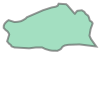

In [23]:
vienna_shape

In [24]:
gdf = gpd.GeoDataFrame({'geometry': grid_list}, crs="EPSG:4326")
gdf['spatial_semantic_vector'] = gdf['geometry']

1853

In [33]:
gdf.loc[0:10]['geometry'].apply(spatial_semantic_vector_obj.generate_vec)

next open slot in 59 seconds waiting till then
next open slot in 69 seconds waiting till then
overpass server is busy
overpass server is busy
next open slot in 28 seconds waiting till then
next open slot in 71 seconds waiting till then
next open slot in 51 seconds waiting till then
next open slot in 4 seconds waiting till then


0     [0.44819424, -0.132106, 0.3962305, -0.632352, ...
1     [0.29798108, -0.24755278, 0.1947402, -0.590901...
2     [-0.00063644786, -0.2682107, 0.33497152, -0.48...
3     [0.4478447, -0.21296225, 0.31879655, -0.754470...
4     [-0.29311875, -0.13042557, 0.11163474, 0.13867...
5     [0.115443945, -0.6666655, 0.32190603, 0.020804...
6     [0.31762004, -0.46473914, 0.3907549, -0.490924...
7     [0.4509349, -0.4605284, 0.120413944, -0.481650...
8     [0.38929763, -0.665089, 0.77616835, -0.7282647...
9     [0.10958157, -0.32191333, 0.29175583, -0.47591...
10    [0.044755775, -0.39766186, 0.23807086, -0.3522...
Name: geometry, dtype: object